# Oriented FAST and Rotated BRIEF (ORB)
Object detection is one of the most hard task in computer vision, recognize and determine location in the image. To perform this analysis, ORB will be tested. ORB is a very fast algorithm that creates feature vectors (binary vectors of pixel analysis) from the keypoints detected, since it is invariant to rotations, changes in ilumination and noise it is a good approach.

This notebook is going to show how to implement these properties to detect a person's face in an image.

## Imports and loadings
* Remember defaults opencv load is BGR, need to convert to RGB

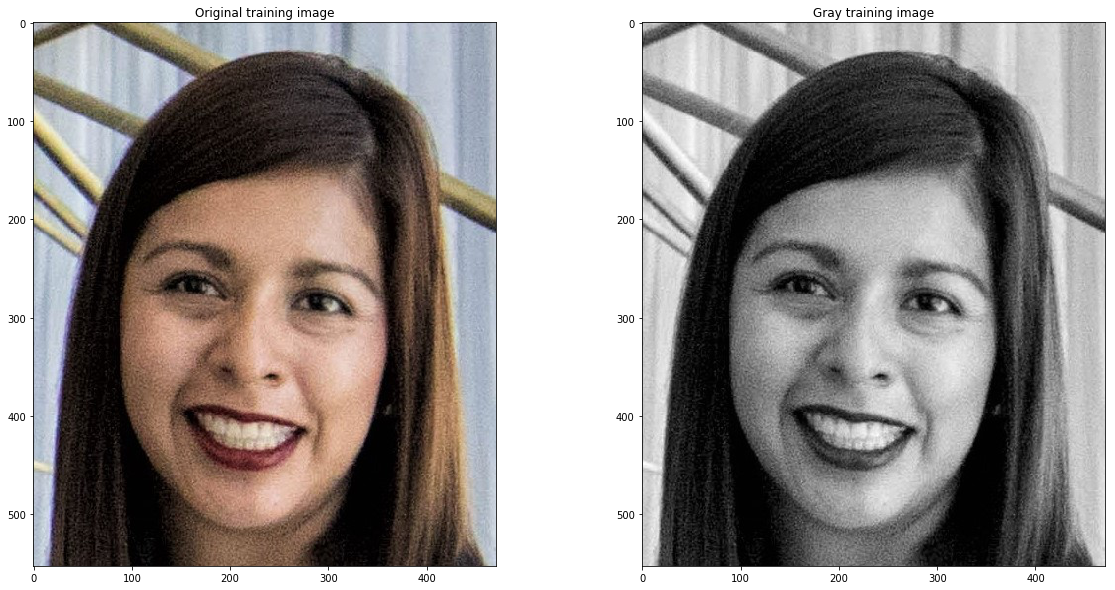

In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

# Set default fig size
plt.rcParams["figure.figsize"] = [20, 10]

img = cv2.imread("images/face.jpeg")

train_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
train_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Original training image")
ax1.imshow(train_img)

ax2.set_title("Gray training image")
ax2.imshow(train_gray, cmap="gray");


## Locating keypoints
The first step in ORB is to locate all keypoins in the training image, after that ORB creates each binary feature vector and groups them together in the ORB descriptor.

Use OpenCV's ORB class to locate the keypoints and create the descriptor. The parameters of ORB algorithm are setup using `ORB_create()`

`cv2.ORB_create(nfeatures = 500,
                scaleFactor = 1.2,
                nlevels = 9,
                edgeThreshold = 31,
                firstLevel = 0,
                WTA_K = 2,
                scoreType = HARRIS_SCORE,
                patchSize = 31,
                fastThreshold = 20)`
                
Parameters:
* **nfeatures** - int
    Determines the max number of features (keypoints to locate).

* **scaleFactor** - float
    Pyramid decimation ratio, must be greater than 1. ORB use pyramid to find features, a factor = 2 means the classical, where each level has 4x less pixel than before. Big scale factor will reduce the number of features found.
    
* **nlevels** - int
    Number of pyramid levels

* **edgeThreshold** - int
    The size of the border where featuers are not detected. This value should be equal or greater than patchSize.
    
* **firstLevel** - int
    Determine which level should be the first level in pyramid.

* **WTA_K** - int
    The number of random pixels used to produce each element of the oriented BRIEF. Default value is 2, but can be more.
    
* **scoreType** - int
    This param can be HARRIS_SCORE or FAST_SCORE. The default is HARRIS and means that harris corner algorithm is used, the fast score usualy produces less stable keypoints (but faster).

* **patchSize** - int
    Size of the patch used by oriented BRIEF. On smaller pyramid layers the perceived image area covered by a feature will be larger.
    
Usualy nfeatures and scaleFactor are the ones to change.

Use `.detectAndCompute(img)` to locate keypoints in the training. Finally use `cv2.darwKeyPoints()` to visualize what was found by ORB.
    


In [4]:
import copy

plt.rcParams["figure.figsize"] = [14, 7]

# Params of ORB to speccify the max number of keypoints
orb = cv2.ORB_create(200, 2)

# Find the keypoints in the gray training image and compute the ORB descriptor, None parm is to indicate that it does not use a mask.
keypoints, descriptor = orb.detectAndCompute(train_gray, None)

# Create copies of the training image to draw later on
keyp_without_size = copy.copy(train_img)
keyp_with_size = copy.copy(train_img)

# Draw the keypoints without size or orientation on one copy of training image
cv2.drawKeypoints(train_img, keypoints, keyp_without_size, color = (0, 255, 0))

# Draw the keypoints with size and orientation on the other copy
cv2.drawKeypoints(train_img, keypoints, keyp_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Keypoints without size and orientation")
ax1.imshow(keyp_without_size)

ax2.set_title("Keypoints with size and orientation")
ax2.imshow(keyp_with_size)

print("Number of keypoints detected: {}".format(len(keypoints)))

Number of keypoints detected: 175


# Feature matching
After having the ORB for both training and query, the next step is to perform keypoint matching between the two images. Usually is performed by a matching called Brute-Force.

`cv2.BFMatcher(normType = cv2.NORM_L2, crossCheck = false)`

Parameters:

* **normType** - Default is the NORM_L2 method (measures the distance between two descriptors), but for binary decisions WTA_K = 2 the NORM_HAMMING is more suitable since compare the pixel by 0 or 1, if WTA_K = 2 the output may be 0, 1 or 2 and thus need 2bits for storage which is what NORM_HAMMING2 is about.

* **crossCheck** - A boolean var which is used for eliminate false matches. Cross checking works in both ways, comparing training -> query and query -> training, only if the match is presented in both  that the keypoint will be valid.

Once the params have been set, use .match(descriptors_train, descriptors_query) to find the matching keypoints. After that use `cv2.drawMatches()` to visualize the matching keypoints found by BFMatcher.

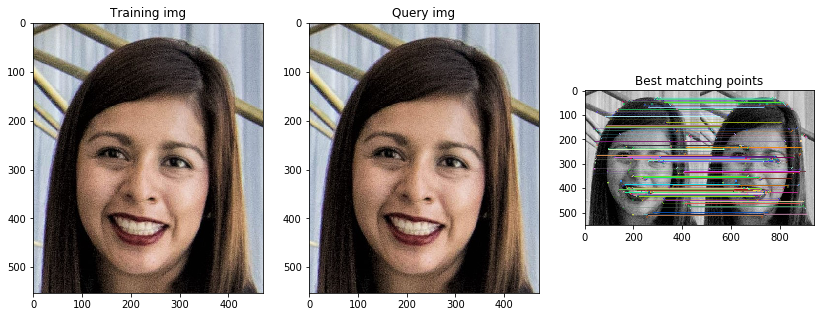

 
          Number of keypoints detected in the training: 821 

          Number of keypoints detected in the query: 821

          Number of matching keypoints between the training and query: 821



In [16]:
import cv2
import matplotlib.pyplot

plt.rcParams["figure.figsize"] = [14, 7]

img1 = cv2.imread("images/face.jpeg")
img2 = cv2.imread("images/face.jpeg")

training_img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
query_img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("Training img")
ax1.imshow(training_img)

ax2.set_title("Query img")
ax2.imshow(query_img);

train_g = cv2.cvtColor(training_img, cv2.COLOR_BGR2GRAY)
query_g = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)

# Set params of ORB, max number of keypoints to locate and pyramid decimation ratio
orb = cv2.ORB_create(1000, 2)

# Find the keypoints in the gray training and query images, compute their ORB descriptor.
# The None is used to indicate that it does not use a mask.
keypoints_train, descriptors_train = orb.detectAndCompute(train_g, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_g, None)

# Create a brute force matcher object. Set crossCheck to True so that BFMatcher will only return consistent pairs.
# It is needed to produce better results with minimal outliers numbers.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the match between ORB of the training img and the query
matches = bf.match(descriptors_train, descriptors_query)

# The matches with shorter distance is searched to be sorted according to distance.
matches = sorted(matches, key = lambda x : x.distance)

# Connect the keypoints in the training img with their best matching in the query img. The best matches correspond to the
# first elements in the sorted list. Draw the first 300 and use flags = 2 to plot the match keypoints without size or 
# orientation.
result = cv2.drawMatches(train_g, keypoints_train, query_g, keypoints_query, matches[:300], query_g, flags = 2)

plt.title("Best matching points")
plt.imshow(result)
plt.show();

print(""" 
          Number of keypoints detected in the training: {} \n
          Number of keypoints detected in the query: {}\n
          Number of matching keypoints between the training and query: {}
""".format(len(keypoints_train), len(keypoints_query), len(matches)))

# ORB's main propoerties

* Scale invariance
* Rotational invariance
* Illumination invariance
* Noise invariance

## Scale Invariance
This means that is able to detect objects in images regardless of their size, to see this it is going to be used in the training image and the query image that is 1/4 the size of the original.


Shape of training image: (553, 471)

Shape of query image: (138, 117)

Number of keypoints detected in training image: 175

Number of keypoints detected in query image: 65

Number of matching keypoints between training and query images: 50



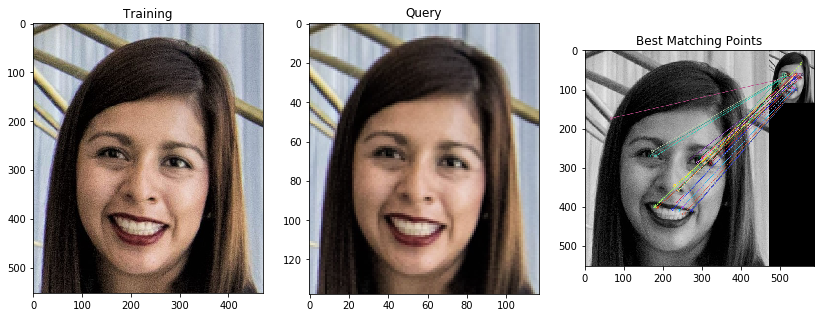

In [50]:
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 7]

img1 = cv2.imread("images/face.jpeg")
img2 = cv2.imread("images/faceQS.png")

training_image = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
query_image = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("Training")
ax1.imshow(training_image)

ax2.set_title("Query")
ax2.imshow(query_image)

training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)
query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(200, 2)

keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = bf.match(descriptors_train, descriptors_query)

matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:30], query_gray, flags=2)

ax3.set_title("Best Matching Points")
ax3.imshow(result)

print("""
Shape of training image: {}\n
Shape of query image: {}\n
Number of keypoints detected in training image: {}\n
Number of keypoints detected in query image: {}\n
Number of matching keypoints between training and query images: {}
""" .format(training_gray.shape, query_gray.shape, len(keypoints_train), len(keypoints_query), len(matches)));

# Rotational invariance


Number keypoints detected in training: 821

Number keypoints detected in query: 836

Number of matching keypoints: 645



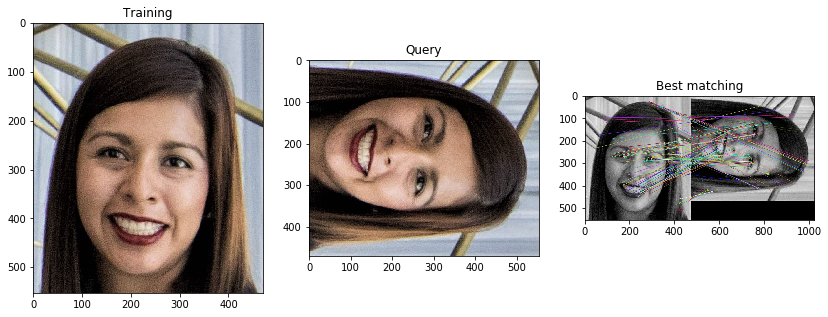

In [51]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

image1 = cv2.imread('./images/face.jpeg')

image2 = cv2.imread('./images/faceR.jpeg')

training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(1000, 2.0)

keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matches = bf.match(descriptors_train, descriptors_query)

matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:100], query_gray, flags = 2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("Training")
ax1.imshow(training_image)

ax2.set_title("Query")
ax2.imshow(query_image)

ax3.set_title("Best matching")
ax3.imshow(result)


print("""
Number keypoints detected in training: {}\n
Number keypoints detected in query: {}\n
Number of matching keypoints: {}
""".format(len(keypoints_train), len(keypoints_query), len(matches)))

# Illumination invariance


Number keypoints detected in training: 821

Number keypoints detected in query: 846

Number of matching keypoints: 503



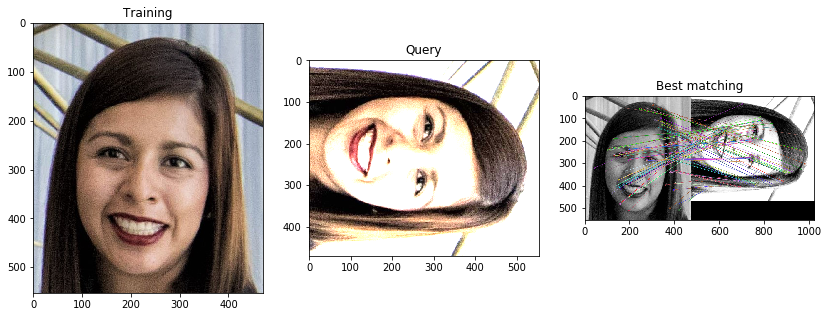

In [53]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

image1 = cv2.imread('./images/face.jpeg')

image2 = cv2.imread('./images/faceRI.png')

training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(1000, 2.0)

keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matches = bf.match(descriptors_train, descriptors_query)

matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:100], query_gray, flags = 2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("Training")
ax1.imshow(training_image)

ax2.set_title("Query")
ax2.imshow(query_image)

ax3.set_title("Best matching")
ax3.imshow(result)


print("""
Number keypoints detected in training: {}\n
Number keypoints detected in query: {}\n
Number of matching keypoints: {}
""".format(len(keypoints_train), len(keypoints_query), len(matches)))

# Noise invariance


Number keypoints detected in training: 883

Number keypoints detected in query: 926

Number of matching keypoints: 537



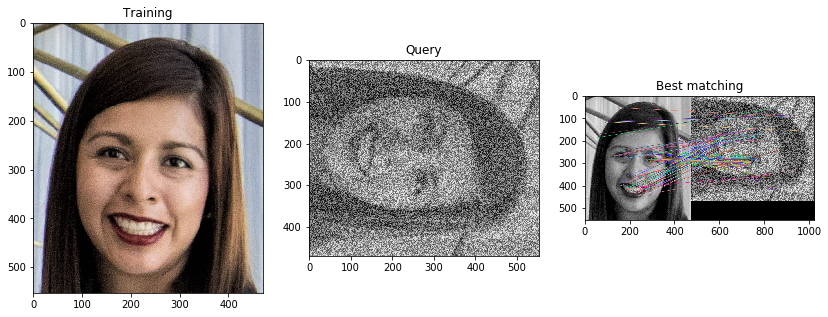

In [57]:
import cv2
import matplotlib.pyplot as plt

# Set the default figure size
plt.rcParams['figure.figsize'] = [14.0, 7.0]

image1 = cv2.imread('./images/face.jpeg')

image2 = cv2.imread('./images/faceRN5.png')

training_image = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

query_image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)


training_gray = cv2.cvtColor(training_image, cv2.COLOR_BGR2GRAY)

query_gray = cv2.cvtColor(query_image, cv2.COLOR_BGR2GRAY)

orb = cv2.ORB_create(1000, 1.3)

keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matches = bf.match(descriptors_train, descriptors_query)

matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:100], query_gray, flags = 2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("Training")
ax1.imshow(training_image)

ax2.set_title("Query")
ax2.imshow(query_image)

ax3.set_title("Best matching")
ax3.imshow(result)


print("""
Number keypoints detected in training: {}\n
Number keypoints detected in query: {}\n
Number of matching keypoints: {}
""".format(len(keypoints_train), len(keypoints_query), len(matches)))

# Object Detection
ORB algorithm detecting face in the training image in another image.

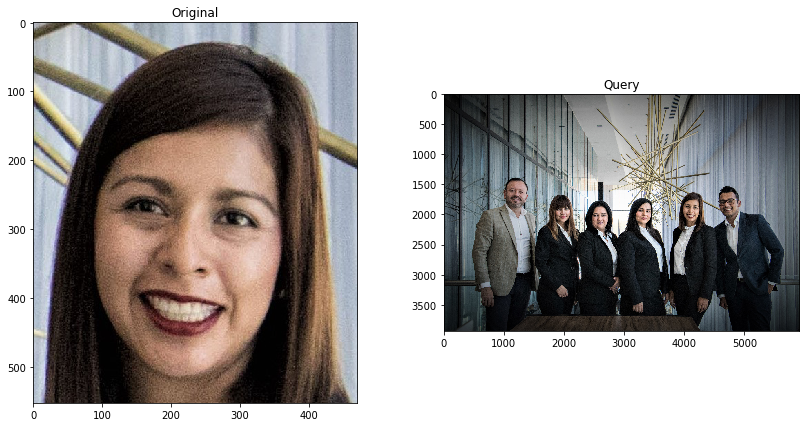

In [65]:
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [14, 7]

img1 = cv2.imread("images/face.jpeg")
img2 = cv2.imread("images/Team.jpeg")

training_img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
query_img = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_title("Original")
ax1.imshow(training_img)

ax2.set_title("Query")
ax2.imshow(query_img)


Number of keypoints detected: 4941

N# Keypoints detected in the training 2506

N# Keypoints detected in query 4941

N# Matching keypoints 1571



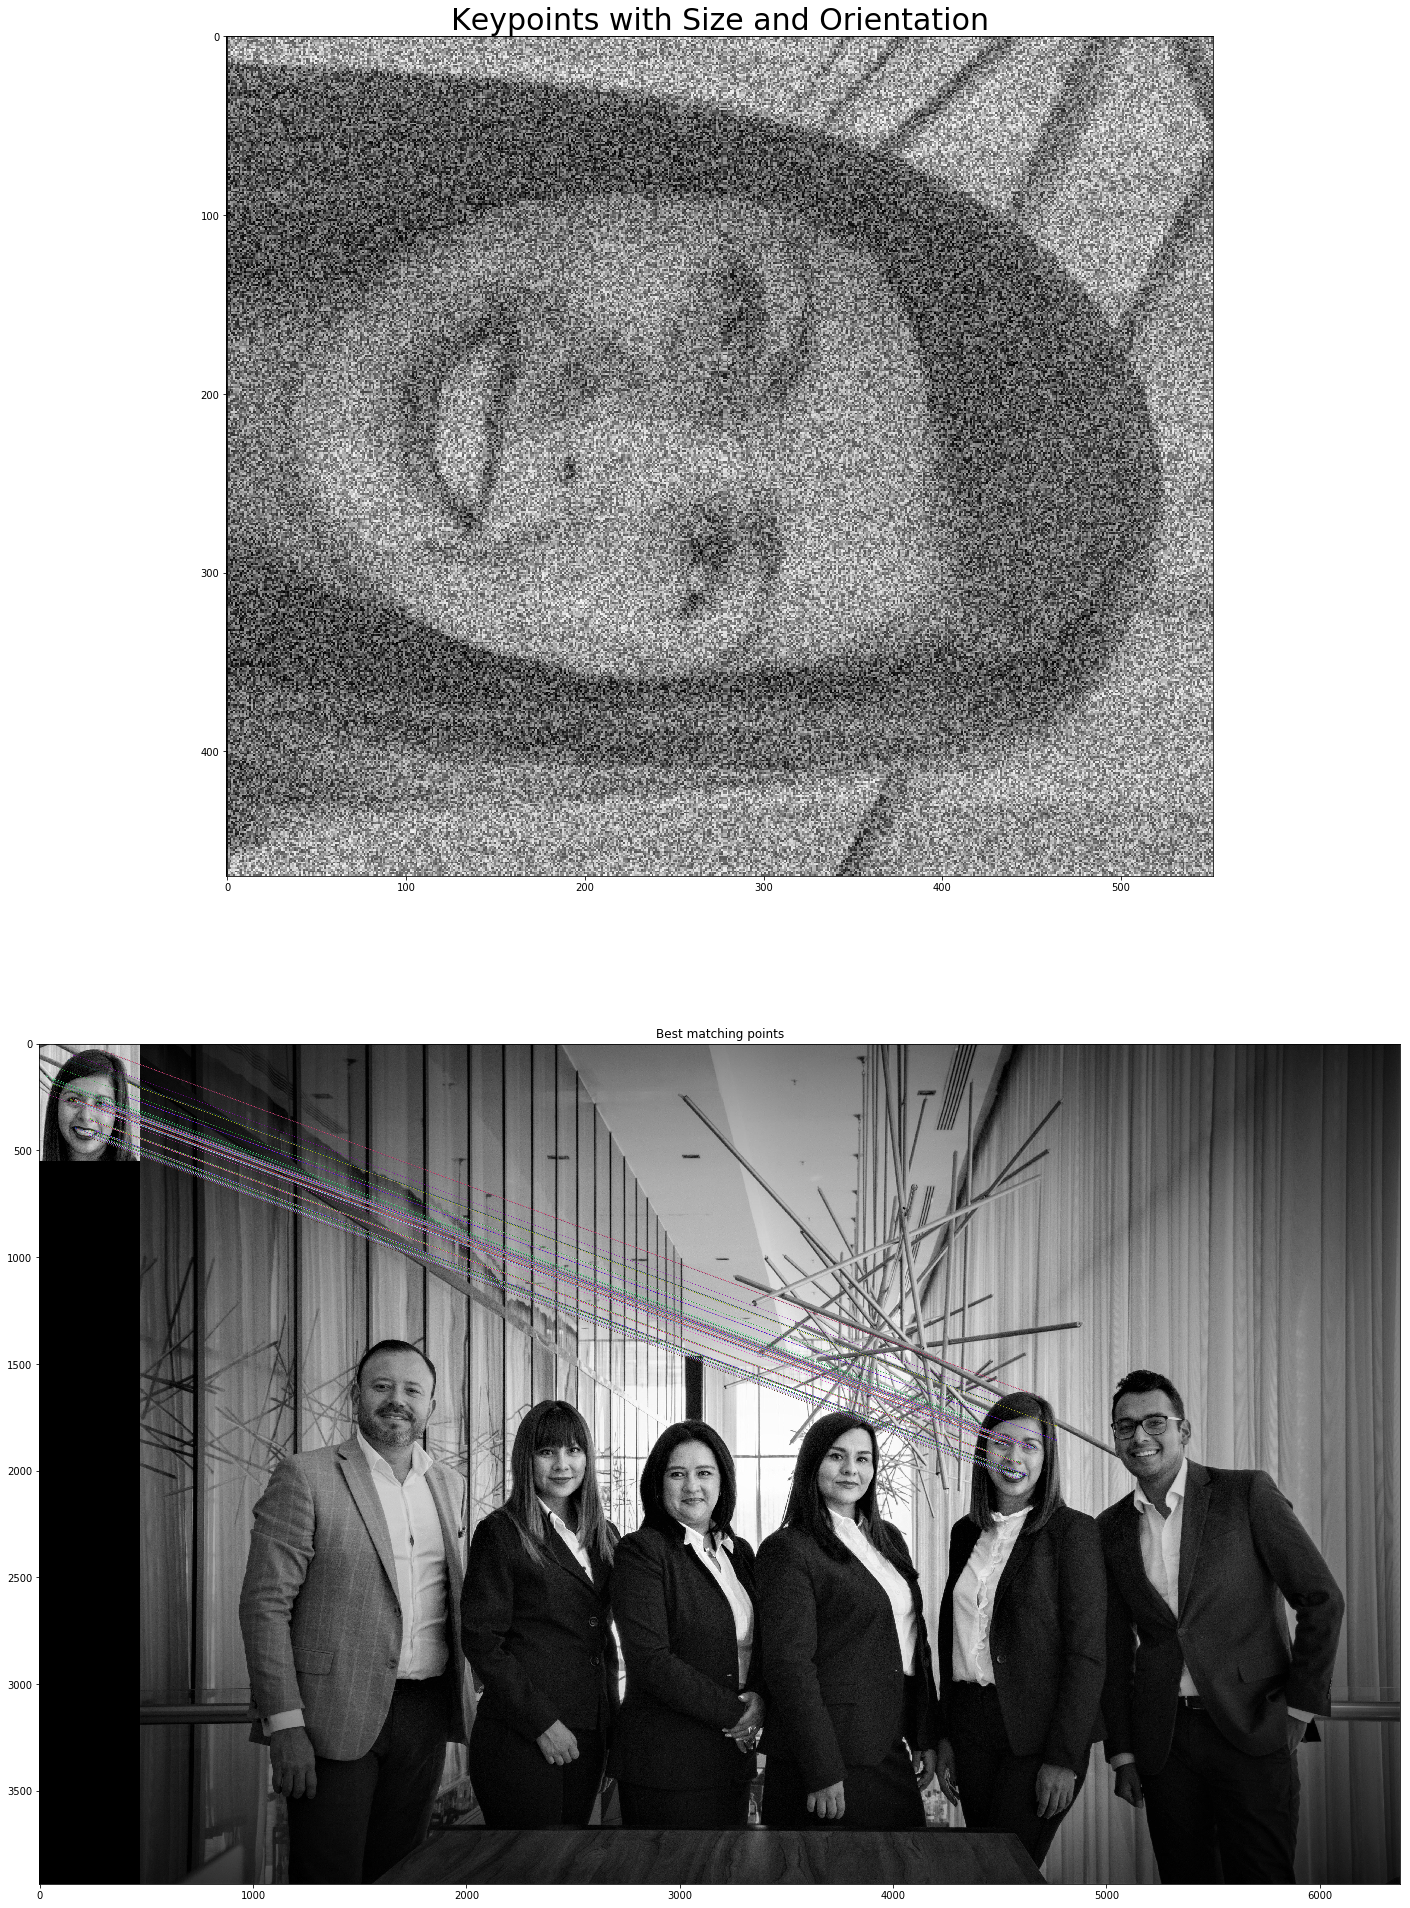

In [69]:
plt.rcParams["figure.figsize"] = [34, 34]

training_gray = cv2.cvtColor(train_img, cv2.COLOR_BGR2GRAY)
query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)

# Set params to max number keypoints and pyramid decimation ratio
orb = cv2.ORB_create(5000, 2)

keypoints_train, descriptors_train = orb.detectAndCompute(training_gray, None)
keypoints_query, descriptors_query = orb.detectAndCompute(query_gray, None)

query_img_keyp = copy.copy(query_image)

cv2.drawKeypoints(query_img, keypoints_query, query_img_keyp, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title('Keypoints with Size and Orientation', fontsize=30)
ax1.imshow(query_img_keyp)

print("\nNumber of keypoints detected: {}" .format(len(keypoints_query)))

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
matches = bf.match(descriptors_train, descriptors_query)
matches = sorted(matches, key = lambda x: x.distance)

result = cv2.drawMatches(training_gray, keypoints_train, query_gray, keypoints_query, matches[:85], query_gray, flags=2)


ax2.set_title("Best matching points")
ax2.imshow(result)

print("""
N# Keypoints detected in the training {}\n
N# Keypoints detected in query {}\n
N# Matching keypoints {}
""" .format(len(keypoints_train), len(keypoints_query), len(matches)))